# Artificial Intelligence

Using the neat algorithm, b2sim can automatically optimize flowcharts using neural networks. In this tutorial document, we showcase how this works. 

In [1]:
import b2sim.engine as b2
import b2sim.analysis as dd
from math import log

## NEAT Algorithm For Idiots

The end-user should have at least a baseline understanding of how the NEAT algorithm works before proceeding. I offer such a baseline understanding of how the algorithm works as follows: First, a population of genomes are tasked to operate the simulator, making decisions in real time concerning what eco sends to use and what farms to buy. When they finish operating the simulator until the target time, they are graded on their performance. The best performers of this population are picked to mate and produce offspring bots that share similar characteristics to their parents. The new populaton of offspring genomes is then asked to operate the simulator themselves where again, upon completion of simulations, the best genomes are picked to reproduce for the next generation of genomes. When the last generation is finished, the winning genome with the best fitness is picked. This winner is the winner the AI has determined to be the winning strategy.

## Basic Experiment Design

Start by declaring the initial game state parameters and the ending time you want to optimize until. To perform optimization with AI, we're going to initialize the *AI* class with the initial game state as the initialization argument.

In [2]:
rounds = b2.Rounds(0.1)

farms = [
    b2.initFarm(rounds.getTimeFromRound(7), upgrades = [3,2,0]),
    b2.initFarm(rounds.getTimeFromRound(13.9), upgrades = [3,2,0])
]

initial_state_game = {
    'Cash': 0,
    'Eco': 600,
    'Rounds': rounds, #Determines the lengths of the rounds in the game state
    'Farms': farms,
    'Game Round': 13.99
}

target_time = rounds.getTimeFromRound(20)

ai = dd.AI(initial_state_game)

## Fitness Functions

To train the AI, you must give it a fitness function which the AI can use to evaluate the effectiveness of a given bot. There are two main fitness functions to get you started:
1. cashGen - Grades bots based on the amount of cash it generates over some time period after the optimization interval. This is useful for greedily optimizing for income generation.
2. terminalCash - Grades bots based on the amount of cash held at some point in time. This point in time can be immediately at the end of the optimization interval, or it could be over some time in the future. 

These fitness functions take two arguments: A GameState class instance, and a *parameters* dictionary containing additional arguments. For more info on how this works, you should read through the function definitions in `fitness.py`. For our first example, we will utilize cashGen fitness.

Below, I set the parameters so that the bots will be graded based on the amount of cash the simulation generates over the next 4 rounds after the end of the optimization interval. For this particular example, that means I'm grading the AI based on cash generated from the start of R20 to the end of R24. I'm also asking the AI to generate strategies which produce a minimum of 1000 eco by simulation end.

In [3]:
parameters = {
    'Unit Type': 'Rounds', # Unit of time to measure cash generation over
    'Units To Measure': 3, # How many rounds (or seconds) after the simulation end should we track cash generation?
    'Minimum Eco': 1000, # Genomes which produce less than this amount of eco will be penalized
    'Eco Tolerance': 100 # Genomes which produce less than the minimum eco minus the eco tolerance will be graded zero. 
    # The tolerance variable allows genomes to only be partially penalized if they miss the minimum eco by a small amount.
}

## Training

We are now ready to train the AI. As a fair warning, good training sessions take some time. I recommend doing something else in the background while waiting for the AI to return its results. The `increment_value` determines how frequently genomes are polled for input on what action to take next. You can increase this value for faster training at the risk of the AI failing to return good results.

In [4]:
ai.train(target_time, dd.cashGen, parameters, num_generations = 50, increment_value = 0.25, log = False)


 ****** Running generation 0 ****** 

Population's average fitness: 9064.13900 stdev: 7081.89208
Best fitness: 16304.69579 - size: (2, 8) - species 1 - id 67
Average adjusted fitness: 0.556
Mean genetic distance 1.150, standard deviation 0.309
Population of 150 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    0   150  16304.696    0.556     0
Total extinctions: 0
Generation time: 9.804 sec

 ****** Running generation 1 ****** 

Population's average fitness: 12612.12460 stdev: 5920.53987
Best fitness: 16312.56607 - size: (2, 8) - species 1 - id 283
Average adjusted fitness: 0.773
Mean genetic distance 1.214, standard deviation 0.315
Population of 150 members in 1 species:
   ID   age  size   fitness   adj fit  stag
  ====  ===  ====  =========  =======  ====
     1    1   150  16312.566    0.773     0
Total extinctions: 0
Generation time: 9.957 sec (9.881 average)

 ****** Running generation 2 ****** 

Population's 

## Interpreting the AI's Results

Once we've determined a winning genome, it's time to see how it behaves! The `simulate` method tells the AI to automatically run a simulation given the previously defined game state until the designated target time. When the AI is finished, you can analyze its decision making by graphing the simulation results and also viewing its decision history.

,Time,Type,Message
0,284.8,Eco,Change eco to Zero
1,284.8,Eco,Change eco to Zero
2,285.0,Round,Round 14 start
3,290.8,Eco,Change eco to Grouped Pinks
4,297.0,Round,Round 15 start
5,313.4,Round,Round 16 start
6,346.4,Round,Round 17 start
7,385.7,Round,Round 18 start
8,411.8,Round,Round 19 start
9,448.2,Round,Round 20 start


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,4850.0,0,4850.0,20965.0,447.0,448.0
1,4850.0,0,4850.0,20965.0,447.0,448.0


24520.800000000367

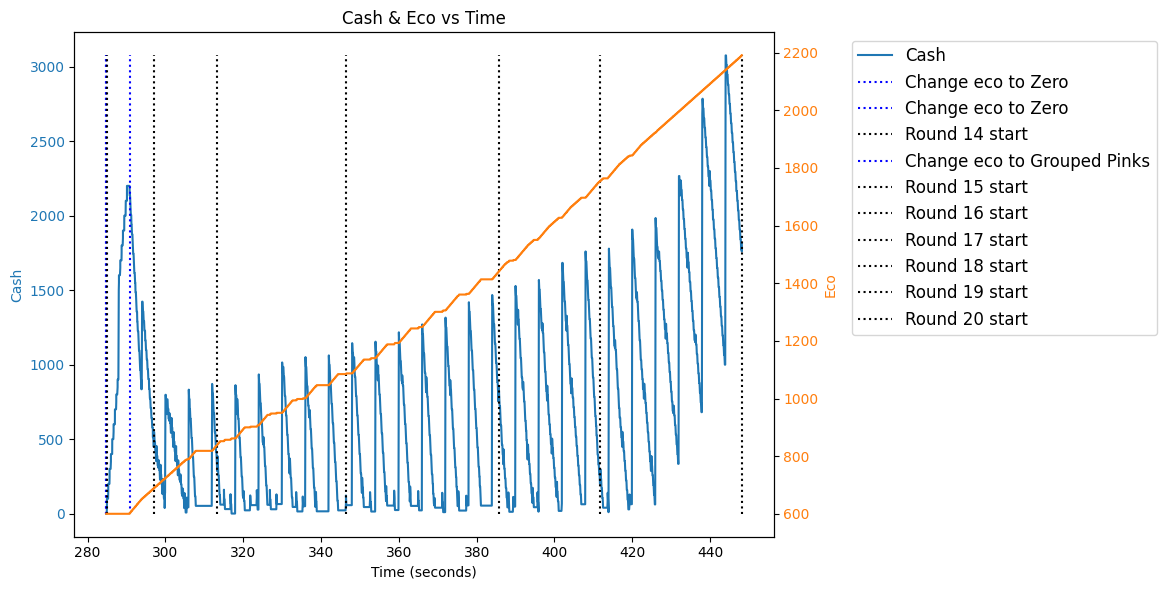

In [5]:
ai.simulate(target_time)
dd.viewHistory(ai.game_state)
dd.cashGen(ai.game_state, parameters = parameters)

In [6]:
ai.game_state.farms

[(3,2,0) Farm ACTIVE, (3,2,0) Farm ACTIVE]

## Comparing Against Human Play

In [7]:
buy_queue = [
    [b2.sellFarm(index=1), b2.upgradeFarm(index = 0,upgrades = (4,2,0))]
]

eco_queue = [
    b2.ecoSend(send_name = 'Grouped Blacks', time = 0),
    b2.ecoSend(send_name = 'Zero', time = rounds.getTimeFromRound(19))
]

initial_state_game = {
    'Cash': 0,
    'Eco': 600,
    'Eco Queue': eco_queue,
    'Buy Queue': buy_queue,
    'Rounds': rounds, #Determines the lengths of the rounds in the game state
    'Farms': farms,
    'Game Round': 13.99
}

[{'Time': 222.29999999999998, 'Send Name': 'Grouped Blacks', 'Max Send Amount': None, 'Fortified': False, 'Camoflauge': False, 'Regrow': False, 'Max Eco Amount': None, 'Max Send Time': None, 'Queue Threshold': 6}, {'Time': 411.8, 'Send Name': 'Zero', 'Max Send Amount': None, 'Fortified': False, 'Camoflauge': False, 'Regrow': False, 'Max Eco Amount': None, 'Max Send Time': None, 'Queue Threshold': 6}]


,Time,Type,Message
0,284.8,Eco,Change eco to Grouped Blacks
1,285.0,Round,Round 14 start
2,297.0,Round,Round 15 start
3,313.4,Round,Round 16 start
4,346.4,Round,Round 17 start
5,385.7,Round,Round 18 start
6,411.8,Round,Round 19 start
7,411.8,Eco,Change eco to Zero
8,438.0,Buy,"Sell farm 1, Upgrade farm 0 to (4,2,0)"
9,448.2,Round,Round 20 start


,Revenue,Expenses,Profit,Eco Impact,Start Time,End Time
Farm Index,,,,,,
0,5450.0,21750,-16300.0,200.0,285.0,448.0
1,8725.0,0,8725.0,342.0,285.0,438.0


27045.0

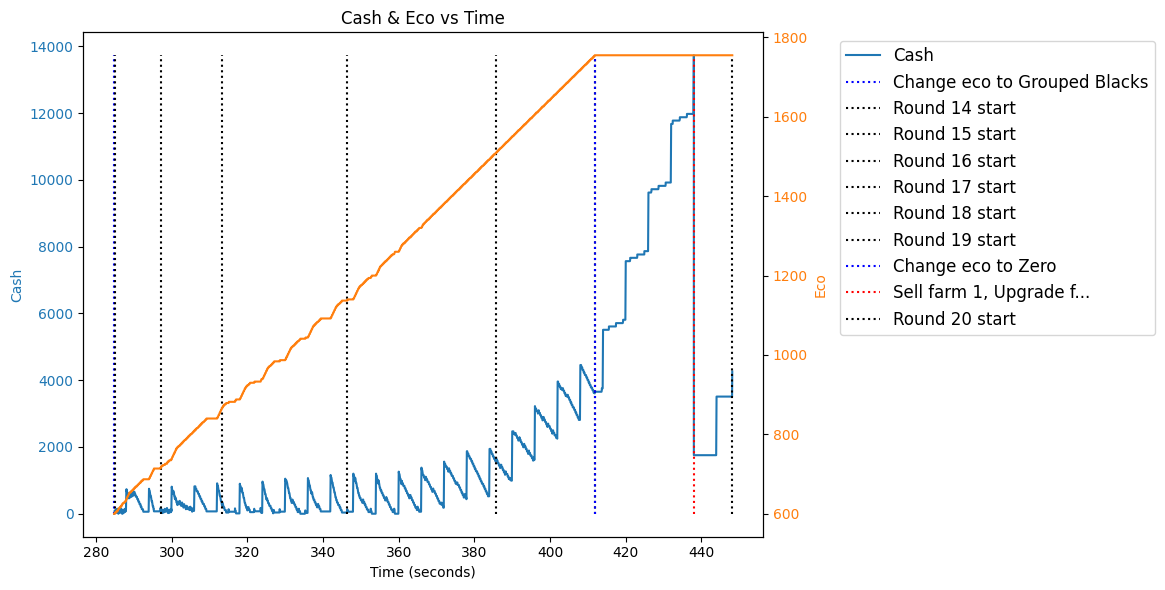

In [8]:
game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round=20)
dd.viewHistory(game_state)
dd.cashGen(game_state, parameters = parameters)

In [9]:
a = [1,2,3]
b = [4,5,6]
a = a + b

In [10]:
a

[1, 2, 3, 4, 5, 6]

In [6]:
def foo(x):
    return ((1/x)-1)*log(1-x)+1

foo(0.9999)

0.9990788738501881